In [ ]:
%%markdown 
# radio data preprocessing with LibROSA

In [1]:
import pandas as pd
import numpy as np

# import data

known = pd.read_csv('known.csv')    
unknown = pd.read_csv('unknown.csv')
csv_headers = ['Signal type', 'Description', 'Frequency', 'Mode', 'Modulation', 'Bandwidth', 'Location', 'Sample Audio', 'Waterfall image']

In [2]:
import re
import math
# frequencies = csv['Frequency']
# bandwidth = csv['Bandwidth']

def get_array(str, dataset):
    arr = []
    for item in dataset[str]:
        arr.append(item)
    return arr

def get_arr_freq(string, dataset):
    arr = []
    for frq in dataset[string]:
        value = ''
        mult = ''
        if isinstance(frq, str):
            frq = re.sub(r'[^\.\S]', '',frq);
            parsed_char = re.sub(r'\d', '',frq);
            parsed_char = re.sub(r'\W', '',parsed_char);

            parsed_val = re.sub(r'[^\.\d]', ' ',frq);
            # print(parsed_val)
            # parsed_val = re.findall(r'\d+', parsed_val)
            parsed_val = re.split(' ', parsed_val)
            while("" in parsed_val) : 
                parsed_val.remove("") 
            mult = parsed_char
            value = parsed_val
        else:
            # parsed = 0
            value = 0
            mult = 1
            arr.append(value*mult)
            continue
        backup = mult
        if len(value) > 1:
            value = (float(value[0]) + float(value[1])) / 2
        else:
            value = float(value[0])
        if mult[0] == 'M':
            mult = 1000000
        elif mult[0] == 'k':
            mult = 1000
        else: 
            mult = 1
        arr.append(value*mult)
    return arr

# for header in csv_headers:
#     data[header] = []
data = {}
for header in csv_headers:
    data_name = header.replace(' ', '_')
    if header != 'Frequency' and header != 'Bandwidth':
        data[data_name] = get_array(header, known)
        data[data_name] += get_array(header, unknown)
    else:
        data[data_name] = get_arr_freq(header, known)
        data[data_name] += get_arr_freq(header, unknown)


In [ ]:
%%markdown
# analyse data with LibROSA

In [26]:
from tqdm import tqdm
from librosa import display
import matplotlib.pyplot as plt
import librosa
import librosa.display

namespace = 'silence'

In [54]:
def extract_silence(path):
    y, sr = librosa.load(path)


    # And compute the spectrogram magnitude and phase
    S_full, phase = librosa.magphase(librosa.stft(y))

    # As a first step, we can plot the root-mean-square (RMS) curve
    rms = librosa.feature.rms(y=y)[0]
    # print(rms)
    times = librosa.frames_to_time(np.arange(len(rms)))

    threshold = 0.02
    # r_normalized = (rms - threshold) / np.std(rms)
    r_normalized = (rms - threshold)
    # print(rms - threshold)
    # print(np.std(rms))
    # print(r_normalized)
    p = np.exp(r_normalized) / (1 + np.exp(r_normalized))
    # print(p)
    transition = librosa.sequence.transition_loop(2, [0.5, 0.6])
    # print(transition)
    full_p = np.vstack([1 - p, p])
    # print(full_p)

    states = librosa.sequence.viterbi_discriminative(full_p, transition)
    # print(p)
    # print(len(states))
    return p
# audio_path = data['Sample_Audio'][43]
data[namespace] = []
for audio_path in data['Sample_Audio']:
# for i in range(25, 28):
#     audio_path = data['Sample_Audio'][i]
    # print(audio_path)
    data[namespace].append(extract_silence(audio_path))

In [55]:

print(len(data[namespace]))

import pickle


with open(namespace + '_data.p', 'wb') as _file:
    pickle.dump(data, _file)

602


In [1]:
import numpy as np
import pickle
namespace = 'silence'
data = pickle.load(open(namespace + '_data.p', 'rb'))


In [56]:

# add SOMpy library and tun it
from operator import itemgetter

import sompylib3.sompy as SOM
from sompylib3.sompy import denormalize_by

# get max length
max_length = 0
for dp in data[namespace]:
    if len(dp) > max_length:
        max_length = len(dp)

print(max_length)

# concatenate the audio features
# data_features = []
# for dp in data[namespace]:
#     freq = np.array(dp[0])
#     time = np.array(dp[1])

#     freq = np.resize(freq, max_length)
#     time = np.resize(time, max_length)

#     # data_features.append([freq, time])
#     data_features.append(freq)

data_features = []
for dp in data[namespace]:

    dp = np.resize(dp, max_length)
    dp = (dp + 0.1)
    # data_features.append([dp, time])
    data_features.append(dp)

data_features = np.array(data_features)

print((data_features).shape)
# print(data_features[0])
# features_shape = (data_features.shape[1], data_features.shape[2])
# concatenated_features = data_features.reshape(602 * features_shape[0], features_shape[1])
# print(concatenated_features.shape)

map_size = [25, 25]

sm = SOM.SOM('', data_features, mapsize = map_size, norm_method = 'var', initmethod='pca')
sm.init_map()
sm.train(trainlen=None, n_job = 1, shared_memory = 'no', verbose='on')


20027
(602, 20027)

initialization method = pca, initializing..

initialization done in 0.369000 seconds

rough training...
radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 32

epoch: 1 ---> elapsed time:  0.692000, quantization error: 106.829684 

epoch: 2 ---> elapsed time:  0.746000, quantization error: 100.681863 

epoch: 3 ---> elapsed time:  0.678000, quantization error: 59.342853 

epoch: 4 ---> elapsed time:  0.634000, quantization error: 46.619575 

epoch: 5 ---> elapsed time:  0.637000, quantization error: 43.973965 

epoch: 6 ---> elapsed time:  0.643000, quantization error: 42.957391 

epoch: 7 ---> elapsed time:  0.690000, quantization error: 42.346487 

epoch: 8 ---> elapsed time:  0.743000, quantization error: 41.912038 

epoch: 9 ---> elapsed time:  0.661000, quantization error: 41.650927 

epoch: 10 ---> elapsed time:  0.634000, quantization error: 41.461596 

epoch: 11 ---> elapsed time:  0.651000, quantization error: 41.230979 

epoch: 12 ---> elapsed time:  

clustering based on default parameters...


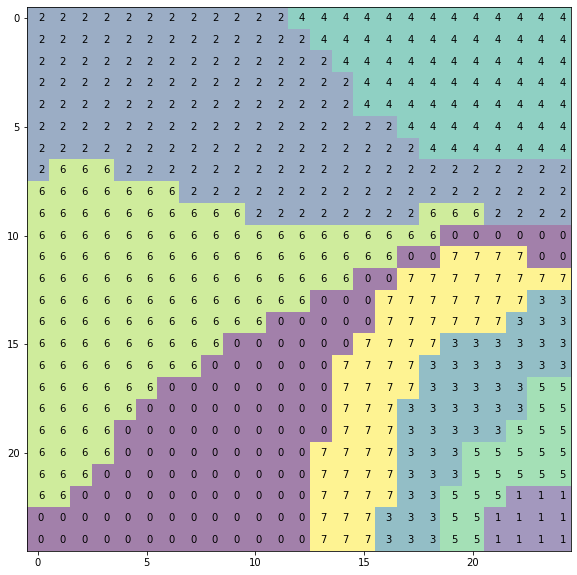

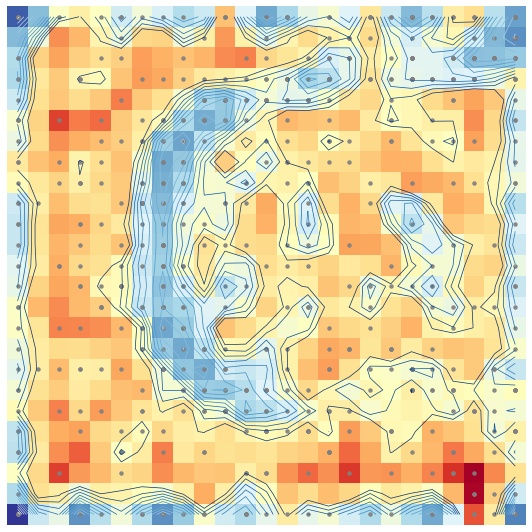

In [57]:
view2D  = sm.hit_map_cluster_number()
view2D  = sm.view_U_matrix()

In [58]:
data['bmus'] = []
# print(np.asarray(data['fingerprints'][0]).shape)
for i in tqdm(range(len(data_features))):
    feature = data_features[i]
    # feature = np.asarray(feature)
    # print(feature.shape)
    # bmu = sm.project_data(np.asarray(feature).reshape(features_shape[0] * features_shape[1], -1))
    bmu = sm.project_data(np.asarray(feature).reshape(1, -1))

    # print(feature.shape)
    data['bmus'].append(bmu.tolist())

100%|██████████| 602/602 [06:03<00:00,  1.65it/s]


In [59]:
print(data['bmus'][233])

[55]


In [60]:
cb = sm.codebook[:]
codebook = {
    'data': cb.tolist(),
    'size': map_size
}
with open(namespace + '_codebook.p', 'wb') as _file:
    pickle.dump(codebook, _file)

with open(namespace + '_data.p', 'wb') as _file:
    pickle.dump(data, _file)